<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/PJI410_reamostragem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJI410 - Reamostragem híbrida

https://medium.com/eni-digitalks/imbalanced-data-an-extensive-guide-on-how-to-deal-with-imbalanced-classification-problems-6c8df0bc2cab

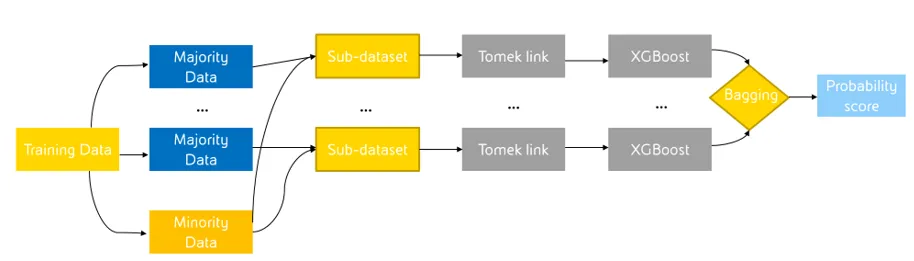

# Importações

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import time

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import TomekLinks

from xgboost import XGBClassifier

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

SEMENTE = 2001088 + 2001247 + 2003061 + 2008193 + 2008620 + 2008880

PALETA = 'summer_r'

# Dados

In [3]:
df_sintomas = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_sintomas.zip')

X = df_sintomas.drop('EVOLUCAO', axis=1)
y = df_sintomas['EVOLUCAO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

treino = pd.concat([X_train, y_train], axis=1)
obito  = treino[treino['EVOLUCAO'] == 0]
cura   = treino[treino['EVOLUCAO'] == 1]

q_curas = int(np.round(len(cura) / len(obito)))
curas   = np.array_split(cura, q_curas)

# Ferramentas

In [4]:
unders = TomekLinks()
modelo = XGBClassifier(n_estimators=50, grow_policy='depthwise', learning_rate=0.5, random_state=SEMENTE)

# Previsões

In [5]:
conjunto = []

for c in range(q_curas):

    print(f"Início conjunto {c}.")

    treino = pd.concat([obito, curas[c]])

    X_train, y_train = treino.drop('EVOLUCAO', axis=1), treino['EVOLUCAO']

    marcacao = time.time()

    X_train, y_train = unders.fit_resample(X_train, y_train)

    print(f"unders: {time.time() - marcacao} segundos.")

    marcacao = time.time()

    modelo.fit(X_train, y_train)

    print(f"modelo: {time.time() - marcacao} segundos.")

    conjunto.append(modelo)

    print()

Início conjunto 0.
unders.fit_resample(X_train, y_train): 1348.5219705104828 segundos.
modelo.fit(X_train, y_train): 18.675196170806885 segundos.

Início conjunto 1.
unders.fit_resample(X_train, y_train): 1332.3679308891296 segundos.
modelo.fit(X_train, y_train): 18.436264753341675 segundos.



In [7]:
previsoes = []

for modelo in conjunto:
    previsoes.append(modelo.predict(X_test))

In [40]:
y_pred = np.mean(previsoes, axis=0, dtype='int')

# Resultados

              precision    recall  f1-score   support

           0       0.42      0.60      0.49     16796
           1       0.77      0.61      0.68     36185

    accuracy                           0.61     52981
   macro avg       0.59      0.61      0.59     52981
weighted avg       0.66      0.61      0.62     52981



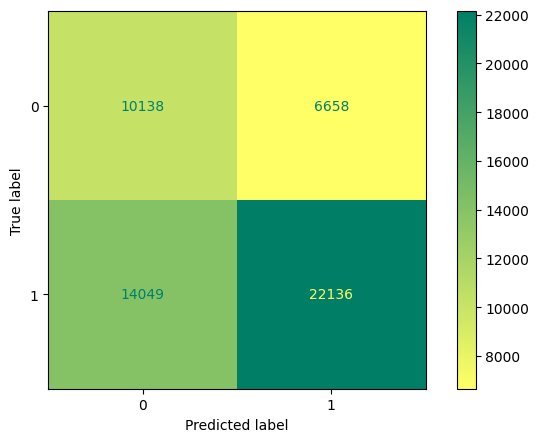

In [42]:
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='d', cmap=PALETA);